In [24]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch

import pandas as pd

In [25]:
test_sub_0 = pd.read_csv('imputation/chuncks/test_sub_0.csv')
test_sub_0 = test_sub_0.drop(columns=['Unnamed: 0'])
test_sub_0.shape

(1700, 428)

In [26]:

def plot_channels(matrix):
    # Extract the first 5 channels from the matrix
    channels = matrix[:, :5]

    # Plot the channels
    fig, axs = plt.subplots(5, 1, figsize=(10, 10))
    for i in range(5):
        axs[i].plot(channels[:, i])
        axs[i].set_ylabel(f'Channel {i+1} Values')

    # Set the plot title and labels
    fig.suptitle('Visualization of First 5 Channels of Multivariate Time Series Data')
    axs[-1].set_xlabel('Time')

    # Display the plot
    plt.show()

In [27]:
EMBEDDINGS_PATH = "/Users/oliver/TU_BERLIN/MASTER/mvts_transformer_/embeddings/TEST_experiment_transformer_Adam_400_0.1_4_gelu_False_2024-07-10_18-24-38/embeddings.pt"
embeddings = torch.load(EMBEDDINGS_PATH)
embeddings.keys()

dict_keys(['embeddings', 'predictions', 'positions', 'y_true'])

In [28]:
embeddings["predictions"][0][0].shape

(1700, 428)

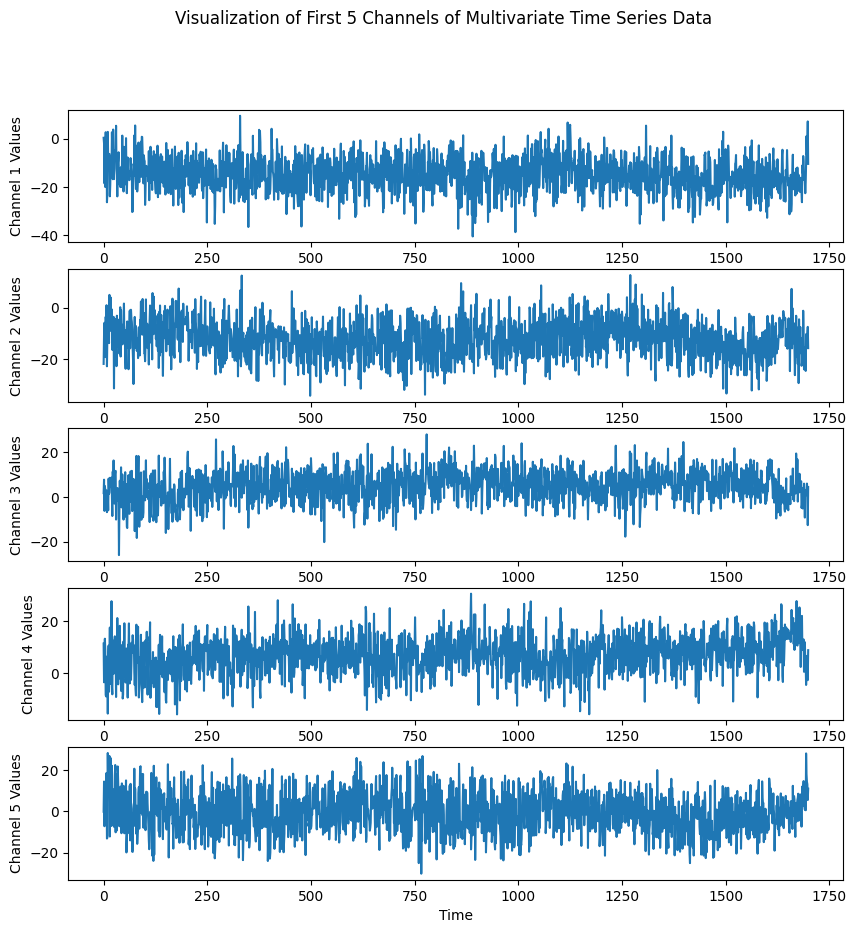

In [29]:
plot_channels(embeddings["predictions"][0][0])

In [30]:
def plot_predicted_time_series(true_series, predicted_series):
    # Create a time axis
    time = np.arange(len(true_series))

    # Plot the true time series
    plt.plot(time, true_series, label='True')

    # Plot the predicted time series
    plt.plot(time, predicted_series, label='Predicted')

    # Set the plot title and labels
    plt.title('True vs Predicted Time Series')
    plt.xlabel('Time')
    plt.ylabel('Value')

    # Add a legend
    plt.legend()

    # Display the plot
    plt.show()

In [34]:
y_true = embeddings["y_true"][0][0][:, 0]
y_pred = embeddings["predictions"][0][0][:, 0]

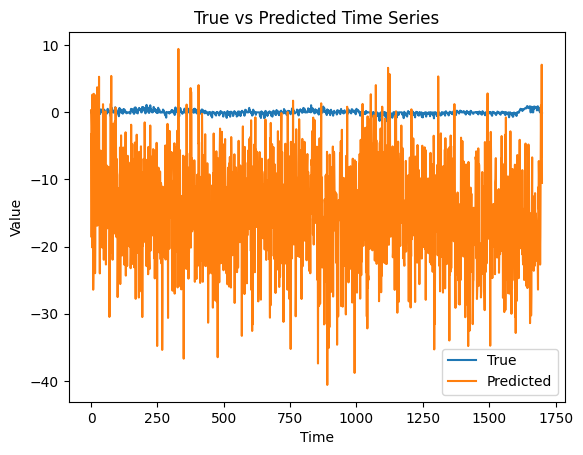

In [36]:
plot_predicted_time_series(y_true, y_pred)

In [37]:
## Next steps 
